## <span style="color:Green">Health Insurance Lead Prediction: </span>

#### Objective

Building a model to predict whether a customer would be interested in Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue.

### <span style="color:Green">This will increase the business of organization if we target selected top probability predicted ID'S </span>

### Import libraries

In [ ]:
import pandas as pd
import numpy as np
import os
import time
from os.path import expanduser
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.preprocessing import KBinsDiscretizer
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate  
from sklearn import metrics
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_precision_recall_curve
from sklearn.model_selection import learning_curve, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


### load the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

LOCAL_FILE_PATH = 'gdrive/MyDrive/hack/'

TRAIN_FILE_PATH  = LOCAL_FILE_PATH + 'train_Df64byy.csv'   #'test_YCcRUnU.csv'

TEST_FILE_PATH = LOCAL_FILE_PATH + 'test_YCcRUnU.csv'

Mounted at /content/gdrive


In [ ]:
train_data = pd.read_csv(TRAIN_FILE_PATH)
test_data = pd.read_csv(TEST_FILE_PATH)

### Summarize Data

In [ ]:
train_data.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [ ]:
test_data.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
0,50883,C1,156,Owned,Individual,30,30,No,NaN,6.0,3.0,5,11934.0
1,50884,C4,7,Owned,Joint,69,68,Yes,X1,3.0,3.0,18,32204.8
2,50885,C1,564,Rented,Individual,28,28,No,X3,2.0,4.0,17,9240.0
3,50886,C3,1177,Rented,Individual,23,23,No,X3,3.0,3.0,18,9086.0
4,50887,C1,951,Owned,Individual,75,75,No,X3,NaN,NaN,5,22534.0


In [ ]:
# check datatypes, shape,null values
print(train_data.info())
print()
print(train_data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  int64  
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         39191 non-null  object 
 9   Holding_Policy_Duration  30631 non-null  object 
 10  Holding_Policy_Type      30631 non-null  float64
 11  Reco_Policy_Cat          50882 non-null  int64  
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
dtypes: float64(2), int64(6

In [ ]:
# check datatypes, shape,null values
print(test_data.info())
print()
print(test_data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21805 entries, 0 to 21804
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       21805 non-null  int64  
 1   City_Code                21805 non-null  object 
 2   Region_Code              21805 non-null  int64  
 3   Accomodation_Type        21805 non-null  object 
 4   Reco_Insurance_Type      21805 non-null  object 
 5   Upper_Age                21805 non-null  int64  
 6   Lower_Age                21805 non-null  int64  
 7   Is_Spouse                21805 non-null  object 
 8   Health Indicator         16778 non-null  object 
 9   Holding_Policy_Duration  13202 non-null  object 
 10  Holding_Policy_Type      13202 non-null  float64
 11  Reco_Policy_Cat          21805 non-null  int64  
 12  Reco_Policy_Premium      21805 non-null  float64
dtypes: float64(2), int64(5), object(6)
memory usage: 2.2+ MB
None

ID           

#### <span style="color:red">There are some missing values in columns in both data set </span>

### Descriptive statistics

In [ ]:
train_data.describe(include='all')  

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
count,50882.000000,50882,50882.000000,50882,50882,50882.000000,50882.000000,50882,39191,30631,30631.000000,50882.000000,50882.000000,50882.000000
unique,NaN,36,NaN,2,2,NaN,NaN,2,9,15,NaN,NaN,NaN,NaN
top,NaN,C1,NaN,Owned,Individual,NaN,NaN,No,X1,1.0,NaN,NaN,NaN,NaN
freq,NaN,8973,NaN,27951,40536,NaN,NaN,42460,13010,4499,NaN,NaN,NaN,NaN
mean,25441.500000,NaN,1732.788707,NaN,NaN,44.856275,42.738866,NaN,NaN,NaN,2.439228,15.115188,14183.950069,0.239947
std,14688.512535,NaN,1424.081652,NaN,NaN,17.310271,17.319375,NaN,NaN,NaN,1.025923,6.340663,6590.074873,0.427055
min,1.000000,NaN,1.000000,NaN,NaN,18.000000,16.000000,NaN,NaN,NaN,1.000000,1.000000,2280.000000,0.000000
25%,12721.250000,NaN,523.000000,NaN,NaN,28.000000,27.000000,NaN,NaN,NaN,1.000000,12.000000,9248.000000,0.000000
50%,25441.500000,NaN,1391.000000,NaN,NaN,44.000000,40.000000,NaN,NaN,NaN,3.000000,17.000000,13178.000000,0.000000
75%,38161.750000,NaN,2667.000000,NaN,NaN,59.000000,57.000000,NaN,NaN,NaN,3.000000,20.000000,18096.000000,0.000000


### <span style="color:Green"> Function to check null columns entries </span>

In [ ]:
def nullColumns(train_data):
    
    list_of_nullcolumns =[]
    for column in train_data.columns:
        total= train_data[column].isna().sum()
        
        try:
            
            if total !=0:
                
                print('Total Na values is {0} for column {1}' .format(total, column))
                
                list_of_nullcolumns.append(column)
        
        except:
            
            print(column,"-----",total)
    
    print('\n')
    return list_of_nullcolumns


def percentMissingFeature(train_data):
    
    data_na = (train_data.isnull().sum() / len(train_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    return data_na



In [ ]:
print('train_data')

print(nullColumns(train_data))

print(percentMissingFeature(train_data))

print('\n')

print('test_data')

print(nullColumns(test_data))

print(percentMissingFeature(test_data))

train_data
Total Na values is 11691 for column Health Indicator
Total Na values is 20251 for column Holding_Policy_Duration
Total Na values is 20251 for column Holding_Policy_Type


['Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type']
Holding_Policy_Type        39.799929
Holding_Policy_Duration    39.799929
Health Indicator           22.976691
dtype: float64


test_data
Total Na values is 5027 for column Health Indicator
Total Na values is 8603 for column Holding_Policy_Duration
Total Na values is 8603 for column Holding_Policy_Type


['Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type']
Holding_Policy_Type        39.454254
Holding_Policy_Duration    39.454254
Health Indicator           23.054345
dtype: float64


### <span style="color:Green"> Check for dataset balance on *Response* </span>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Response')

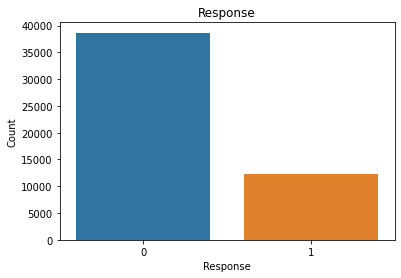

In [ ]:
response = train_data.loc[:,"Response"].value_counts().rename('Count')
plt.xlabel("Response")
plt.ylabel('Count')
sns.barplot(response.index , response.values).set_title('Response')

### <span style="color:Green"> Useful plots for assumtion to make  </span>

In [ ]:
def plot(df_ls,variable_dict):
    """
    Some EDA plots useful function
    """
    v2 = df_ls[variable_dict['variable']].value_counts()

    plt.figure(figsize=(15,6))
    splot = sns.barplot(v2.index, v2.values, alpha=0.8)
    plt.title(variable_dict['title'], fontsize=15)
    plt.ylabel(variable_dict['ylabel'], fontsize=12)
    plt.xlabel(variable_dict['xlabel'], fontsize=12,)

    plt.xticks(
        rotation=30, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='small'  
    )

    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

    #plt.grid(True)
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


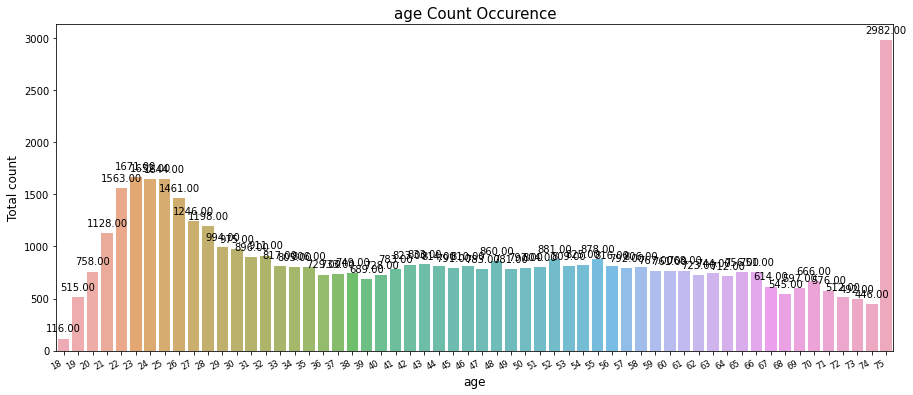

In [ ]:
variable_dict = {'variable':'Upper_Age','title':'age Count Occurence',
             'xlabel':'age','ylabel':'Total count'}
plot(train_data, variable_dict)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


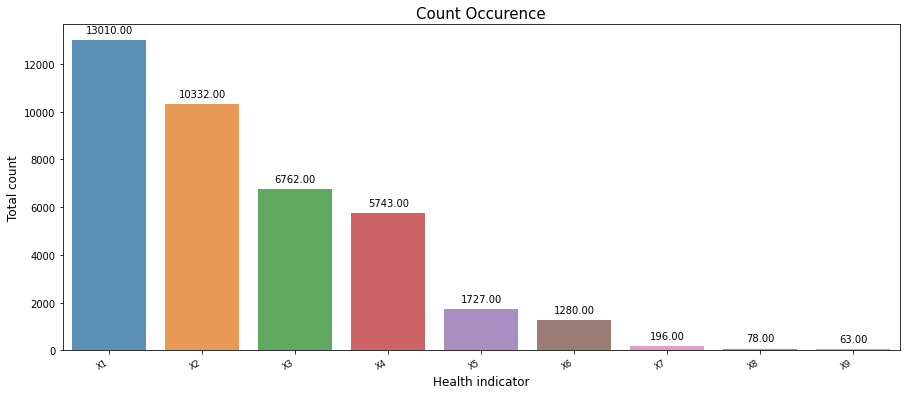

In [ ]:

variable_dict = {'variable':'Health Indicator','title':'Count Occurence',
             'xlabel':'Health indicator','ylabel':'Total count'}
plot(train_data, variable_dict)

###  <span style="color:red"> Holding policy duration & holding policy types have some nann values </span>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


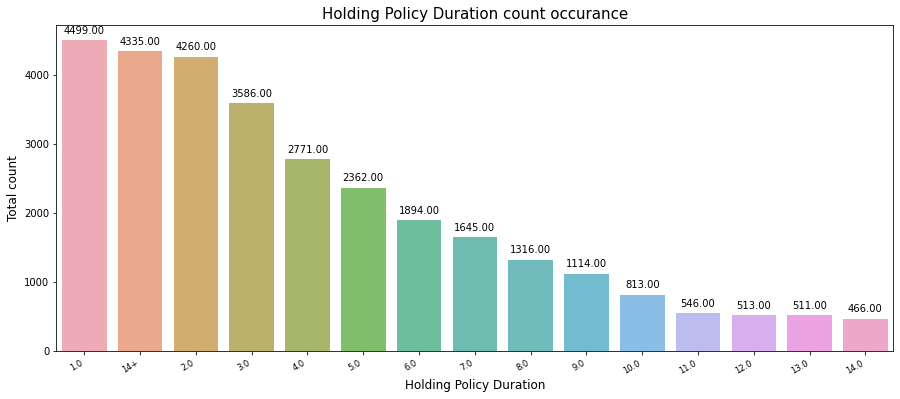

In [ ]:
variable_dict = {'variable':'Holding_Policy_Duration','title':'Holding Policy Duration count occurance',
             'xlabel':'Holding Policy Duration','ylabel':'Total count'}
plot(train_data, variable_dict)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


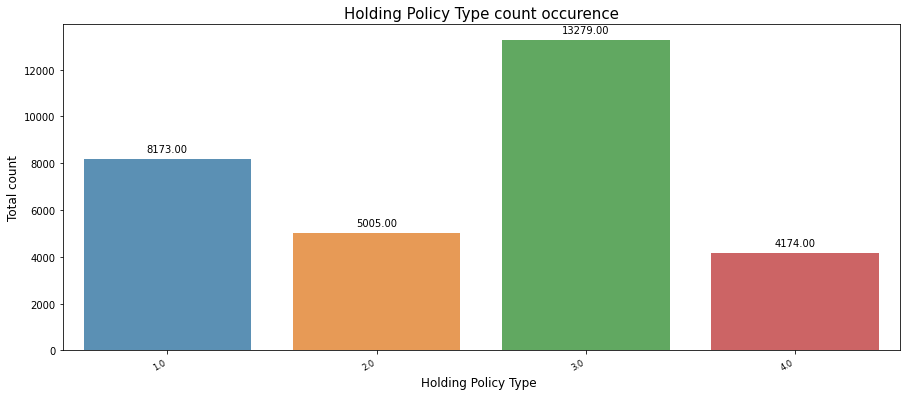

In [ ]:
variable_dict = {'variable':'Holding_Policy_Type','title':'Holding Policy Type count occurence',
             'xlabel':'Holding Policy Type ','ylabel':'Total count'}
plot(train_data, variable_dict)

In [ ]:
policy_holder = train_data.loc[train_data['Holding_Policy_Type'].notnull()]

###  <span style="color:green"> Age VS Response </span>

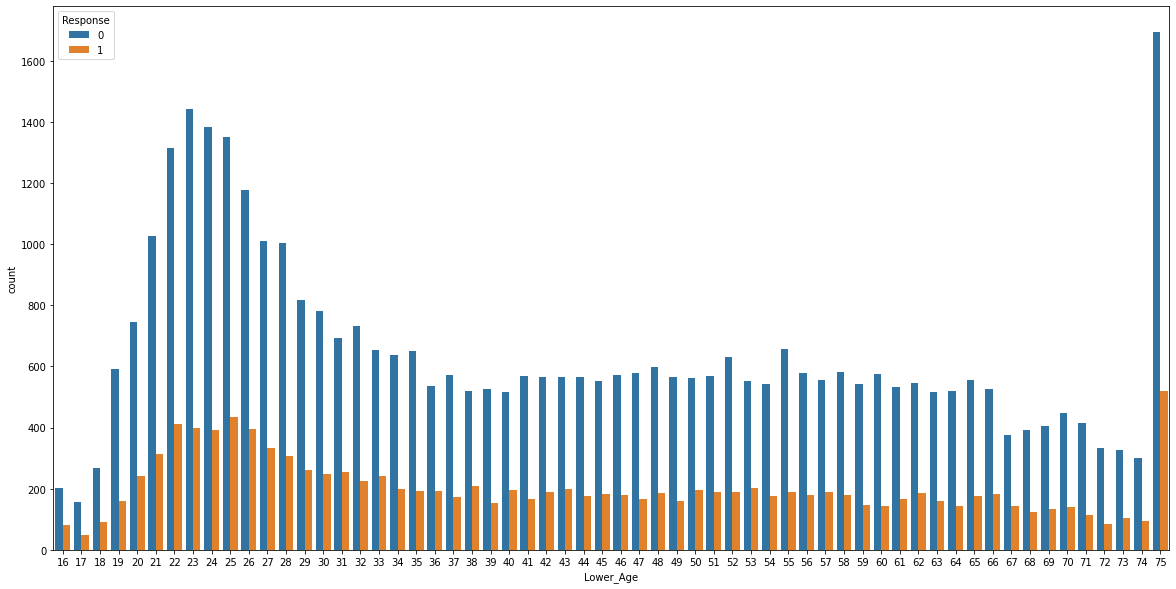

In [ ]:
#
plt.figure(figsize=(20,10))
sns.countplot(x='Lower_Age',hue='Response',data=train_data)

#### Young people below 20 are not interested in insurance. Reasons could be lack of experience, less maturity level and they don't have expensive vehicles yet.
#### People aged above 20 are more likely to be interested.


###  <span style="color:green"> Policy_holder Vs Response </span>

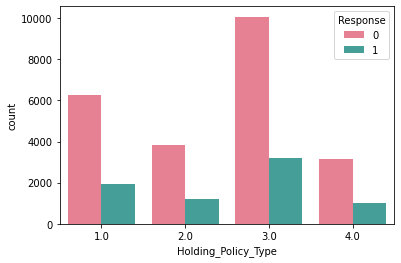

In [ ]:
sns.countplot(x='Holding_Policy_Type',hue='Response',data=train_data,palette='husl')

all policy holder are like to have same response % wise

###  <span style="color:green"> Create some features </span>

In [ ]:
def feature_add(train_data):
    train_data['Holding_Policy_Duration'] = train_data['Holding_Policy_Duration'].fillna(0)
    train_data.loc[train_data['Holding_Policy_Duration']== '14+', 'Holding_Policy_Duration'] = 15
    train_data['Holding_Policy_Duration'] = train_data['Holding_Policy_Duration'].astype(float)
    train_data['Policy_taken_age_up'] = train_data['Upper_Age'] - train_data['Holding_Policy_Duration']
    train_data['Policy_taken_age_down'] = train_data['Lower_Age'] - train_data['Holding_Policy_Duration']
    train_data['Age_avg'] = train_data[['Upper_Age', 'Lower_Age']].mean(axis=1)
    train_data['City_Region'] = train_data['Holding_Policy_Type'].astype(str)+'_'+train_data['City_Code'].astype(str)
    
    return train_data

In [ ]:
train_data = feature_add(train_data)
test_data = feature_add(test_data)

In [ ]:
train_data.isnull().sum()

ID                             0
City_Code                      0
Region_Code                    0
Accomodation_Type              0
Reco_Insurance_Type            0
Upper_Age                      0
Lower_Age                      0
Is_Spouse                      0
Health Indicator           11691
Holding_Policy_Duration        0
Holding_Policy_Type        20251
Reco_Policy_Cat                0
Reco_Policy_Premium            0
Response                       0
Policy_taken_age_up            0
Policy_taken_age_down          0
Age_avg                        0
City_Region                    0
dtype: int64

In [ ]:
# set index as ID & fill nan with 0 as they each Id are independent
train_data = train_data.set_index('ID')
test_data = test_data.set_index('ID')
train_data = train_data.fillna(0)
test_data = test_data.fillna(0)

In [ ]:
cat_features = ['City_Code','Accomodation_Type','Reco_Insurance_Type','Is_Spouse','Health Indicator','Holding_Policy_Type',
               'Reco_Policy_Cat','City_Region']

cont_features = ['Upper_Age','Lower_Age',' Holding_Policy_Duration','Policy_taken_age_up','Policy_taken_age_down','age_avg']


label = 'Response'

train_data[cat_features]= train_data[cat_features].astype(str)
test_data[cat_features] = test_data[cat_features].astype(str)

### <span style="color:Green"> Function for encoding columns </span>

In [ ]:
from sklearn.preprocessing import LabelEncoder

def encode_cat_cols(train, test, cat_cols): #target

    train_df = train_data.copy()
    test_df = test_data.copy()
    
    # Making a dictionary to store all the labelencoders for categroical columns to transform them later.
    
    le_dict = {}
    for col in cat_cols:
        
        le = LabelEncoder()
        le.fit(train_df[col].unique().tolist() + test_df[col].unique().tolist())
        train_df[col] = le.fit_transform(train_df[[col]])
        test_df[col] = le.fit_transform(test_df[[col]])
        le_dict[col] = le
        
    le = LabelEncoder()
    train_df[label] = le.fit_transform(train_df[[label]])
    le_dict[label] = le
    
    
    return train_df, test_df, le_dict

In [ ]:
train_df, test_df, le_dict = encode_cat_cols(train_data,test_data,cat_features)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
train_df = train_df.reset_index('ID')
test_df = test_df.reset_index('ID')

In [ ]:
train_df['train'] = 1
test_df['train'] = 0

combined_data = pd.concat([train_df,test_df],axis =0).reset_index(drop = True).copy()

### Some Feature creation

In [ ]:

combined_data['Nunq_Policy_Per_city'] = combined_data.groupby('City_Code')['Holding_Policy_Type'].transform('nunique') 
combined_data['SDev_Annual_Premium_Per_Region_Code_int'] = combined_data.groupby('City_Code')['Reco_Policy_Premium'].transform('std').fillna(-1) 
combined_data['Nunq_Region_Per_Premium'] = combined_data.groupby('Reco_Policy_Premium')['City_Code'].transform('nunique')
combined_data['SDev_Annual_Premium_Per_Region_Code_dec'] = combined_data['SDev_Annual_Premium_Per_Region_Code_int'] %1
combined_data['SDev_Annual_Premium_Per_Region_Code_int'] =combined_data['SDev_Annual_Premium_Per_Region_Code_int'].astype(int)
combined_data['Avg_Policy_Region_Age'] = combined_data.groupby(['City_Region'])['Age_avg'].transform('mean')
combined_data['Avg_Policy_Region_Premium'] = combined_data.groupby(['City_Region'])['Reco_Policy_Premium'].transform('mean') 
combined_data['Avg_Region_Premium'] = combined_data.groupby(['City_Code'])['Reco_Policy_Premium'].transform('mean')


### <span style="color:Green">As Reco_Policy_Premium has some outliers, so replace outliers with high & low values </span>

In [ ]:
Q1 = combined_data["Reco_Policy_Premium"].quantile(0.25)
Q3 = combined_data["Reco_Policy_Premium"].quantile(0.75)
IQR = Q3 - Q1
low_limit = Q1 - (IQR * 1.5)
high_limit = Q3 + (IQR * 1.5)

combined_data['Reco_Policy_Premium'] = np.where(combined_data['Reco_Policy_Premium'] > high_limit, high_limit, combined_data['Reco_Policy_Premium'])
combined_data['Reco_Policy_Premium'] = np.where(combined_data['Reco_Policy_Premium'] < low_limit, low_limit, combined_data['Reco_Policy_Premium'])
            

#### seperate data

In [ ]:
train_df = combined_data[combined_data['train']==1]
test_df = combined_data[combined_data['train']==0]

train_df = train_df.set_index('ID')
test_df  = test_df.set_index('ID')

In [ ]:
train_df.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,Policy_taken_age_up,Policy_taken_age_down,Age_avg,City_Region,train,Nunq_Policy_Per_city,SDev_Annual_Premium_Per_Region_Code_int,Nunq_Region_Per_Premium,SDev_Annual_Premium_Per_Region_Code_dec,Avg_Policy_Region_Age,Avg_Policy_Region_Premium,Avg_Region_Premium
ID,,,,,,,,,,,,,,,,,,,,,,,,,
1,22,3213,1,0,36,36,0,1,15.0,3,14,11628.0,0.0,21.0,21.0,36.0,93,1,5,6269,17,0.275264,47.165907,14980.368717,13805.713057
2,31,1117,0,1,75,22,0,2,0.0,0,14,30510.0,0.0,75.0,22.0,48.5,174,1,5,6047,2,0.186241,35.321942,11770.904317,13335.386551
3,31,3732,0,0,32,32,0,0,1.0,1,10,7450.0,1.0,31.0,31.0,32.0,31,1,5,6047,5,0.186241,41.177419,13587.262903,13335.386551
4,16,4378,0,1,52,48,0,1,15.0,3,10,17780.0,0.0,37.0,33.0,50.0,87,1,5,6617,15,0.138435,49.641844,15966.231206,14939.971081
5,34,2190,1,0,44,44,0,2,3.0,1,7,10404.0,0.0,41.0,41.0,44.0,34,1,5,6053,12,0.509278,40.658854,12848.738021,13292.158976


### <span style="color:Green">Check correlation bet variables , if they are highly co-related then drop any one </span>

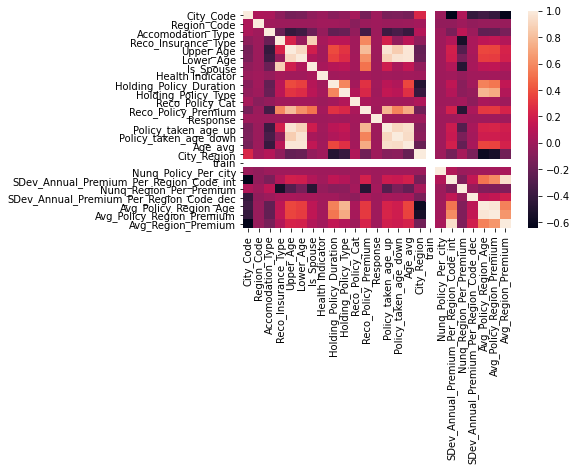

In [ ]:
corr=train_df.corr()
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [ ]:
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "6pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '100px'),
                        ('font-size', '6pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '40px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:1126: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:1127: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,Policy_taken_age_up,Policy_taken_age_down,Age_avg,City_Region,train,Nunq_Policy_Per_city,SDev_Annual_Premium_Per_Region_Code_int,Nunq_Region_Per_Premium,SDev_Annual_Premium_Per_Region_Code_dec,Avg_Policy_Region_Age,Avg_Policy_Region_Premium,Avg_Region_Premium
City_Code,1.00,0.06,0.05,-0.05,-0.14,-0.14,-0.05,-0.01,-0.08,-0.04,0.03,-0.14,-0.00,-0.13,-0.12,-0.14,0.25,nan,-0.01,-0.64,0.07,-0.41,-0.37,-0.41,-0.64
Region_Code,0.06,1.00,0.01,-0.00,-0.01,-0.01,-0.00,0.01,0.01,0.00,-0.08,-0.01,0.00,-0.01,-0.01,-0.01,0.02,nan,-0.04,-0.05,0.00,-0.05,-0.02,-0.02,-0.02
Accomodation_Type,0.05,0.01,1.00,-0.20,-0.42,-0.37,-0.19,-0.03,-0.22,-0.20,-0.04,-0.35,-0.01,-0.38,-0.33,-0.40,0.09,nan,-0.01,-0.13,0.13,-0.00,-0.23,-0.22,-0.14
Reco_Insurance_Type,-0.05,-0.00,-0.20,1.00,0.23,-0.01,0.88,0.04,0.11,0.11,0.01,0.59,0.01,0.21,-0.05,0.11,-0.05,nan,0.01,0.08,-0.55,0.05,0.12,0.13,0.08
Upper_Age,-0.14,-0.01,-0.42,0.23,1.00,0.92,0.20,0.02,0.38,0.30,0.02,0.80,0.00,0.96,0.87,0.98,-0.22,nan,0.01,0.21,-0.28,0.04,0.37,0.36,0.22
Lower_Age,-0.14,-0.01,-0.37,-0.01,0.92,1.00,0.06,0.01,0.34,0.26,0.02,0.62,-0.00,0.89,0.96,0.98,-0.20,nan,0.01,0.19,-0.14,0.03,0.34,0.33,0.21
Is_Spouse,-0.05,-0.00,-0.19,0.88,0.20,0.06,1.00,0.04,0.09,0.11,0.02,0.51,0.00,0.19,0.04,0.14,-0.04,nan,0.01,0.08,-0.48,0.04,0.12,0.13,0.08
Health Indicator,-0.01,0.01,-0.03,0.04,0.02,0.01,0.04,1.00,0.01,0.02,-0.01,0.03,0.00,0.01,0.01,0.01,0.01,nan,-0.00,0.01,-0.03,0.01,0.02,0.02,0.01
Holding_Policy_Duration,-0.08,0.01,-0.22,0.11,0.38,0.34,0.09,0.01,1.00,0.58,0.02,0.29,0.01,0.11,0.07,0.37,-0.48,nan,0.00,0.13,-0.08,0.01,0.56,0.53,0.14
Holding_Policy_Type,-0.04,0.00,-0.20,0.11,0.30,0.26,0.11,0.02,0.58,1.00,0.08,0.24,0.01,0.14,0.11,0.29,-0.40,nan,-0.00,0.09,-0.06,-0.03,0.77,0.73,0.08


### <span style="color:Green"> Drop unwanted features & split the data set for training </span>

In [ ]:
target = train_df['Response']
train_df = train_df.drop(columns =['train','Region_Code','Upper_Age','Lower_Age','Response','Nunq_Policy_Per_city','SDev_Annual_Premium_Per_Region_Code_int'])
test_df = test_df.drop(columns=['train','Region_Code','Upper_Age','Lower_Age','Response','Nunq_Policy_Per_city','SDev_Annual_Premium_Per_Region_Code_int'])


In [ ]:
y=target
X=train_df.loc[:, ~train_df.columns.isin(['Response'])]

In [ ]:
# split dataset into train , test, validation data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

### <span style="color:Green">Xgboost classifier results </span>

Can do Parameter tunning so that we can improve accuracy of our model

In [ ]:
%%time
model = xgb.XGBClassifier(n_estimators=500, max_depth=8,learning_rate=0.1,
                                subsample=0.8, scale_pos_weight= 3)   #.2

# model.fit(X, y)
# model.fit(X_train, y_train)

CPU times: user 52.7 s, sys: 80.8 ms, total: 52.8 s
Wall time: 52.9 s


In [ ]:
# Predicting the Test set results 
y_pred = model.predict(X_test)    
print('Accuracy score of test data:= ', accuracy_score(y_test, y_pred) )
print('Diffrent measures =:','\n')
print('F1 score Micro  =:',f1_score(y_test, y_pred,average='micro'),'\n')
print('F1 score Macro =:',f1_score(y_test, y_pred, average='macro'),'\n')
print('F1 score Weighted  =:',f1_score(y_test, y_pred, average='weighted'),'\n')
print('F1 score for each class =:','\n',f1_score(y_test, y_pred, average=None),'\n')

print('-'* 50)
print('Accuracy score of test data:= ', accuracy_score(y_test, y_pred) )    
results1 = confusion_matrix(y_test, y_pred) 
print ('Confusion Matrix on test =:')
print(results1) 
    
y_valPre = model.predict(X_val)
    
print('Accuracy score of val data:= ', accuracy_score(y_val, y_valPre) )
results2 = confusion_matrix(y_val, y_valPre) 
print ('Confusion Matrix of validation data set =:')
print(results2,'\n')       

    

Accuracy score of test data:=  0.9391765746290656
Diffrent measures =: 

F1 score Micro  =: 0.9391765746290656 

F1 score Macro =: 0.9225617804099748 

F1 score Weighted  =: 0.9408436933532127 

F1 score for each class =: 
 [0.95843127 0.88669229] 

--------------------------------------------------
Accuracy score of test data:=  0.9391765746290656
Confusion Matrix on test =:
[[7136  546]
 [  73 2422]]
Accuracy score of val data:=  0.9408470079591235
Confusion Matrix of validation data set =:
[[7285  532]
 [  70 2290]] 



In [ ]:
print('classification report of test data')
print (classification_report(y_test,y_pred))

classification report of test data
              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96      7682
         1.0       0.82      0.97      0.89      2495

    accuracy                           0.94     10177
   macro avg       0.90      0.95      0.92     10177
weighted avg       0.95      0.94      0.94     10177



In [ ]:
print('classification report of validate data')
print (classification_report(y_val,y_valPre))

classification report of validate data
              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96      7817
         1.0       0.81      0.97      0.88      2360

    accuracy                           0.94     10177
   macro avg       0.90      0.95      0.92     10177
weighted avg       0.95      0.94      0.94     10177



#### AUC

In [ ]:
probs = model.predict_proba(X_test)
probs = probs[:, 1]
auc = roc_auc_score(y_test, probs)
print('AUC of test data: %.5f' % auc)


AUC of test data: 0.99086


#### ROC

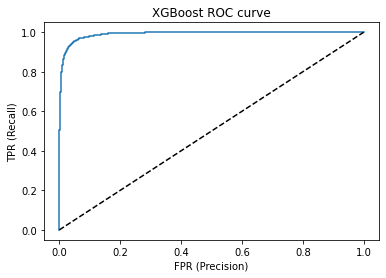

In [ ]:
XGB_probability = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, XGB_probability)

plt.title('XGBoost ROC curve')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)')

plt.plot(fpr,tpr)
plt.plot((0,1), ls='dashed',color='black')
plt.show()

## <span style="color:Green"> Feature importnace </span>

Based upon feature importance we can drop those feature which have less importance

In [ ]:
feature_imp_value = model.feature_importances_
X_key = []
X_key = X_train.columns
feature_imp = {X_key[i]: feature_imp_value[i] for i in range(len(X_key))} 
feature_imp1 = pd.DataFrame(feature_imp.items(), columns=['FEATURE', 'IMPORTANCE_VALUE'])
dfeature = feature_imp1.sort_values(by=['IMPORTANCE_VALUE'],ascending=False)
dfeature


,FEATURE,IMPORTANCE_VALUE
7,Reco_Policy_Cat,0.083788
6,Holding_Policy_Type,0.076531
2,Reco_Insurance_Type,0.066503
12,City_Region,0.063699
17,Avg_Region_Premium,0.061923
14,SDev_Annual_Premium_Per_Region_Code_dec,0.061599
16,Avg_Policy_Region_Premium,0.053469
11,Age_avg,0.052775
10,Policy_taken_age_down,0.051782
0,City_Code,0.051489


## <span style="color:Green"> Prediction for submission  </span>

In [ ]:
# reverse engineering for production
prediction = model.predict_proba(test_df)[:, 1]
# create output df
df_out = test_df.reset_index()
df_out["Response"] = prediction
df_out = df_out[['ID','Response']]
df_out

,ID,Response
0,50883,0.211525
1,50884,0.432462
2,50885,0.522965
3,50886,0.372228
4,50887,0.450480
...,...,...
21800,72683,0.115540
21801,72684,0.080670
21802,72685,0.005868
21803,72686,0.101364


In [ ]:
df_out.to_csv( LOCAL_FILE_PATH + 'final_prediction_8.csv', index=False)

## <span style="color:Green"> Some conclusion </span>


<span style="color:Blue">
    
* age above 20-50 are likely to buy insurance
    

* Reco_Policy_Cat, Holding_Policy_Type are most imported features
    

* If Holding_Policy_Type is of type 1 or 3, then they have more chances of cross selling insurance
    

* If Holding policy duration in in bet 1, 2, 4 or more than 14 years then we have more chance to cross sell
    
</span>    